# Goal: Predict Mortality

* The task is a ML supervised, binary classification of mortality
* The synthetic data is  from http://hdx.mitre.org/downloads/syntheticmass/100k_synthea_covid19_csv.zip 
* The data is unbalanced as mortality = 19.5% and the majority voting / guess accuracy = 80.5%  
* The best performance metric to monitor is F1 score with accuracy, precision, recall and AUC


## Problems 

* Original data is in 16 tables in a relational format – needs to be flattened
* While there are a several numerical features (age, longitude, latitude, etc.)…
* Data is mostly categorical and highly dimensional (many meds, conditions, observations, etc.)
* One Hot Encoding the categorical features will create a sparse matrix (aka curse of dimensionality)

## Plan
* Categorical concepts embedding / vectorization instead of OHE
* Use these vectors as features (aka representational learning) together with the other numerical features
* Create new features as the number of all interactions between patient – system (number of meds, labs, care-plans, providers, etc.)
* ALL the above categories of features - at once

## Results 
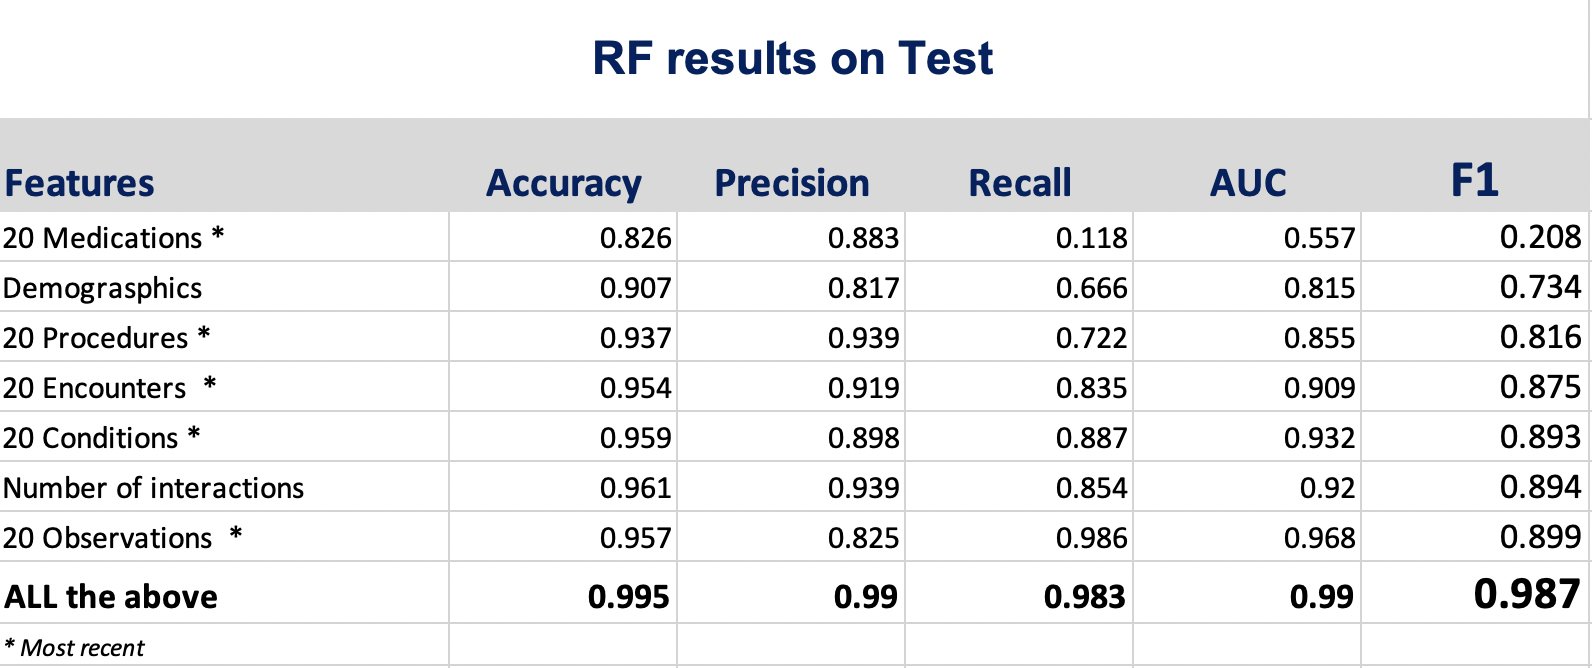

### Future
* Keras double input NN (simple NN on numericals and RNN on emebeddings, concatenated before the last sigmoid layer)

In [2]:
import numpy as np  
import pandas as pd  
import os
from typing import Tuple
import pickle
import seaborn as sns
import time
from collections import Counter, OrderedDict

import gc
gc.enable()

import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
from matplotlib.pyplot import figure
%matplotlib inline
#from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_predict

""" # Not used in this notebook
import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences"""

pd.options.display.max_columns =999
pd.options.display.max_rows = 999

#from pdpbox import pdp, get_dataset, info_plots
#import shap 
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

data_path = 'data/100k_synthea_covid19_csv/'
listFiles = os.listdir(data_path)
listFiles

['medications.csv',
 'providers.csv',
 'payer_transitions.csv',
 'imaging_studies.csv',
 'supplies.csv',
 'payers.csv',
 'allergies.csv',
 'procedures.csv',
 'organizations.csv',
 'conditions.csv',
 'careplans.csv',
 'encounters.csv',
 'devices.csv',
 'immunizations.csv',
 'patients.csv',
 'Synthea COVID-19 Analysis.html',
 'observations.csv']

In [3]:
# Function for a nice CM

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Data

In [4]:
patients = pd.read_csv(data_path + 'patients.csv')
print(patients.shape)
patients.sample()

(124150, 25)


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
6524,d56d1979-b740-4cb7-968c-a1c4d9fd8e7f,1921-10-24,NaN,999-48-8342,S99939008,X66436465X,Mrs.,Enriqueta274,Ondricka197,NaN,Gusikowski974,M,black,nonhispanic,F,Milton Massachusetts US,708 Fay Harbor,Norfolk,Massachusetts,Norfolk County,NaN,42.159877,-71.327208,1398697.36,19335.37


In [5]:
# Number of unique patients
len(patients.Id.unique())

124150

In [6]:
# Mortality rate
patients.DEATHDATE.value_counts().sum() / len(patients.Id.unique())

0.1945227547321788

In [7]:
# Sample ML dataset
RawData4ML = patients.copy()
RawData4ML = RawData4ML[['Id', 'BIRTHDATE', 'DEATHDATE','MARITAL', 'RACE', 'ETHNICITY',
       'GENDER','LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']]
RawData4ML.sample()

,Id,BIRTHDATE,DEATHDATE,MARITAL,RACE,ETHNICITY,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
77967,59a3f4f0-8df7-472d-a353-bf30c356b9ef,1920-03-09,2020-03-14,M,white,nonhispanic,M,42.133554,-71.016866,1481463.52,32557.02


In [9]:
# Reads in data from other CSV files for observations, careplans, etc.

%%time

# assign dataset names
list_of_names = ['observations.csv',
 'careplans.csv',
 'conditions.csv',
 'encounters.csv',
 'procedures.csv',
 'allergies.csv',
 'medications.csv',
 'payers.csv',
 'organizations.csv',
 'imaging_studies.csv',
 'supplies.csv',
 'patients.csv',
 'devices.csv',
 'payer_transitions.csv',
 'providers.csv',
 'immunizations.csv']

# create empty list
dataframes_list = []
  
for name in list_of_names:
    name = name[:-4]
    print(name, end=' ')
    name = pd.read_csv(data_path+str(name)+".csv")
    dataframes_list.append(name)
    print(name.shape)

observations (16219969, 8)
careplans (377726, 9)
conditions (1143900, 6)
encounters (3188675, 15)
procedures (979564, 8)
allergies (51592, 6)
medications (4227723, 13)
payers (10, 21)
organizations (9175, 11)
imaging_studies (45609, 10)
supplies (1389858, 6)
patients (124150, 25)
devices (23694, 7)
payer_transitions (409553, 5)
providers (60534, 12)
immunizations (168160, 6)
CPU times: user 59.5 s, sys: 18.7 s, total: 1min 18s
Wall time: 1min 52s


In [10]:
observations = dataframes_list[0]
careplans = dataframes_list[1]
conditions = dataframes_list[2]
encounters = dataframes_list[3]
procedures = dataframes_list[4]
allergies = dataframes_list[5]
medications = dataframes_list[6]
payers = dataframes_list[7]
organizations = dataframes_list[8]
imaging_studies = dataframes_list[9]
supplies = dataframes_list[10]
patients = dataframes_list[11]
devices = dataframes_list[12]
payer_transitions = dataframes_list[13]
providers = dataframes_list[14]
immunizations = dataframes_list[15]

print(observations.shape)
print(careplans.shape)
print(conditions.shape)
print(encounters.shape)
print(procedures.shape)
print(allergies.shape)
print(medications.shape)
print(payers.shape)
print(organizations.shape)
print(imaging_studies.shape)
print(supplies.shape)
print(patients.shape)
print(devices.shape)
print(payer_transitions.shape)
print(providers.shape)
print(immunizations.shape)


(16219969, 8)
(377726, 9)
(1143900, 6)
(3188675, 15)
(979564, 8)
(51592, 6)
(4227723, 13)
(10, 21)
(9175, 11)
(45609, 10)
(1389858, 6)
(124150, 25)
(23694, 7)
(409553, 5)
(60534, 12)
(168160, 6)


In [11]:
del dataframes_list
gc.collect()

2058

# Prevent data leakage ... Feature contains word DEATH

In [10]:
# Any features that contain the word death are leaky.
# observations has 18,134 Cause of Death
print(observations.shape)
observations = observations.loc[~observations['DESCRIPTION'].str.contains("death", case=False)]
print(observations.shape)

# encounters 18,134 Death certificate
print(encounters.shape)
encounters = encounters.loc[~encounters['DESCRIPTION'].str.contains("death", case=False)]
print(encounters.shape)

# conditions , procedures ...No label leakage
print(conditions.loc[conditions['DESCRIPTION'].str.contains("death", case=False)].shape)
procedures.loc[procedures['DESCRIPTION'].str.contains("death", case=False)].shape

(16219969, 8)
(16201835, 8)
(3188675, 15)
(3170541, 15)
(0, 6)


(0, 8)

# Count number of interactions between patient and system

In [11]:
%%time

conditionsCount = conditions.groupby('PATIENT').size().reset_index(name='NumConditions')
conditionsCount.columns = ['Id','NumConditions']

proceduresCount = procedures.groupby('PATIENT').size().reset_index(name='NumProcedures')
proceduresCount.columns = ['Id','NumProcedures']

medicationsCount = medications.groupby('PATIENT').size().reset_index(name='NumMedications')
medicationsCount.columns = ['Id','NumMedications']

observationsCount = observations.groupby('PATIENT').size().reset_index(name='NumObservations')
observationsCount.columns = ['Id','NumObservations']

encountersCount = encounters.groupby('PATIENT').size().reset_index(name='NumEncounters')
encountersCount.columns = ['Id','NumEncounters']

imaging_studiesCount = imaging_studies.groupby('PATIENT').size().reset_index(name='NumImages')
imaging_studiesCount.columns = ['Id','NumImages']

careplansCount = careplans.groupby('PATIENT').size().reset_index(name='NumCareplans')
careplansCount.columns = ['Id','NumCareplans']

allergiesCount = allergies.groupby('PATIENT').size().reset_index(name='NumAllergies')
allergiesCount.columns = ['Id','NumAllergies']

payersCount = payers.groupby('Id').size().reset_index(name='NumPayers')
payersCount.columns = ['Id','NumPayers']

organizationsCount = organizations.groupby('Id').size().reset_index(name='NumOrganizations')
organizationsCount.columns = ['Id','NumOrganizations']

suppliesCount = supplies.groupby('PATIENT').size().reset_index(name='NumSupplies')
suppliesCount.columns = ['Id','NumSupplies']

devicesCount = devices.groupby('PATIENT').size().reset_index(name='NumDevices')
devicesCount.columns = ['Id','NumDevices']

payer_transitionsCount = payer_transitions.groupby('PATIENT').size().reset_index(name='NumPayer_transitions')
payer_transitionsCount.columns = ['Id','NumPayer_transitions']

providersCount = providers.groupby('Id').size().reset_index(name='NumProviders')
providersCount.columns = ['Id','NumProviders']

immunizationsCount = immunizations.groupby('PATIENT').size().reset_index(name='NumImmunizations')
immunizationsCount.columns = ['Id','NumImmunizations']

RawData4ML = RawData4ML.merge(immunizationsCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(providersCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(payer_transitionsCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(devicesCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(suppliesCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(organizationsCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(payersCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(allergiesCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(careplansCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(imaging_studiesCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(encountersCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(observationsCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(medicationsCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(proceduresCount, how='left', on='Id')
RawData4ML = RawData4ML.merge(conditionsCount, how='left', on='Id')

CPU times: user 7.72 s, sys: 386 ms, total: 8.1 s
Wall time: 8.11 s


In [12]:
# Mortality

RawData4ML['Dead'] = 0
RawData4ML['Dead'] = ~RawData4ML.DEATHDATE.isnull()
RawData4ML.drop('DEATHDATE', axis=1, inplace=True)
RawData4ML.Dead.value_counts(normalize=True)

False    0.805477
True     0.194523
Name: Dead, dtype: float64

In [13]:
# Categorical data

print(RawData4ML.shape)
cols4OHE = ['MARITAL', 'RACE', 'ETHNICITY']

RawData4ML = pd.get_dummies(RawData4ML, columns = cols4OHE)
print(RawData4ML.shape)
RawData4ML.isnull().sum()

(124150, 26)
(124150, 32)


Id                            0
BIRTHDATE                     0
GENDER                        0
LAT                           0
LON                           0
HEALTHCARE_EXPENSES           0
HEALTHCARE_COVERAGE           0
NumImmunizations          19704
NumProviders             124150
NumPayer_transitions      17613
NumDevices               113112
NumSupplies              105973
NumOrganizations         124150
NumPayers                124150
NumAllergies             109638
NumCareplans               6029
NumImages                112441
NumEncounters               258
NumObservations             583
NumMedications            28621
NumProcedures              7248
NumConditions              1952
Dead                          0
MARITAL_M                     0
MARITAL_S                     0
RACE_asian                    0
RACE_black                    0
RACE_native                   0
RACE_other                    0
RACE_white                    0
ETHNICITY_hispanic            0
ETHNICIT

In [14]:
# Gender and fillna

RawData4ML['GENDER']=RawData4ML['GENDER'].apply(lambda x: 1 if x =='M'  else 0)
RawData4ML.fillna(value=0, inplace=True)
RawData4ML.isnull().sum()

Id                       0
BIRTHDATE                0
GENDER                   0
LAT                      0
LON                      0
HEALTHCARE_EXPENSES      0
HEALTHCARE_COVERAGE      0
NumImmunizations         0
NumProviders             0
NumPayer_transitions     0
NumDevices               0
NumSupplies              0
NumOrganizations         0
NumPayers                0
NumAllergies             0
NumCareplans             0
NumImages                0
NumEncounters            0
NumObservations          0
NumMedications           0
NumProcedures            0
NumConditions            0
Dead                     0
MARITAL_M                0
MARITAL_S                0
RACE_asian               0
RACE_black               0
RACE_native              0
RACE_other               0
RACE_white               0
ETHNICITY_hispanic       0
ETHNICITY_nonhispanic    0
dtype: int64

In [15]:
# Age

RawData4ML['BIRTHDATE'] = pd.to_datetime(RawData4ML['BIRTHDATE'])
RawData4ML['BIRTHDATE']

now = pd.to_datetime('now')

RawData4ML['Age'] = (now - RawData4ML['BIRTHDATE']).astype('<m8[Y]') 
RawData4ML.drop('BIRTHDATE', axis=1, inplace=True)
RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0


#Prep ONLY num of interactions - REMOVE demographics

RawData4ML = RawData4ML[['Id', 'NumImmunizations', 'NumProviders',
       'NumPayer_transitions', 'NumDevices', 'NumSupplies', 'NumOrganizations',
       'NumPayers', 'NumAllergies', 'NumCareplans', 'NumImages',
       'NumEncounters', 'NumObservations', 'NumMedications', 'NumProcedures',
       'NumConditions', 'Dead']]


In [16]:
# Separate X,y for normalizing only X

# RawData4ML = RawData4ML.sample(frac=1, random_state=42) # shuffles df

y = RawData4ML.Dead.values
print(y.shape)
#X = RawData4ML.drop(['Dead','Id', 'Conditions'], axis=1)
X = RawData4ML.drop(['Dead','Id'], axis=1)
print(X.shape)

# Normalize X

x = X.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)
print(X.shape)
X.tail(1)

(124150,)
(124150, 30)
(124150, 30)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age
124149,0.988229,-1.334822,0.570124,1.755695,0.017704,-0.202289,0.0,-0.332487,-0.186725,-0.393541,0.0,0.0,-0.284126,1.147815,-0.245186,0.212871,-0.346066,-0.076165,-0.521727,0.754689,0.874441,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,1.339122


# Prep concepts for embedding

* Arrange descending order - pick only last, 20 most recent
* Concatenate words into concepts - chronic sinusitis = chronic_sinusitis
* Remove duplicates
* Tokenize
* Vectorize into one dimension
* Add the vectors as features

In [17]:
numFeat = 20

### Conditions

In [18]:
# Concepts are separated by comma ,

conditions.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
conditions.DESCRIPTION = conditions.DESCRIPTION.str.lower()
conditions.DESCRIPTION = conditions.DESCRIPTION.str.replace('(', '')
conditions.DESCRIPTION = conditions.DESCRIPTION.str.replace(')', '')
conditions.DESCRIPTION = conditions.DESCRIPTION.replace(' ', '_', regex=True)
conditionsGr = conditions.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
conditionsGr.columns = ['Id','Conditions']
conditionsGr.head()
RawData4ML = RawData4ML.merge(conditionsGr, how='left', on='Id')

# Remove duplicates

RawData4ML['Conditions'] = (RawData4ML['Conditions'].astype(str).str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Conditions
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0,fever_finding suspected_covid-19 covid-19 otit...


In [19]:
texts = RawData4ML['Conditions'].astype(str).tolist()
print(len(texts))
# Number of concepts: max, mean, std

RawData4ML.Conditions.str.split().str.len().max(),RawData4ML.Conditions.str.split().str.len().mean(), RawData4ML.Conditions.str.split().str.len().std()

124150


(42, 9.12135320177205, 4.9160375683316255)

In [20]:
# Tokenize from words to integers (sequences) ... removed underscore _ the dot . and minus - from the filters

maxlen = numFeat # cut off after this number of words in a text...
max_words = 200 # considers only the top number of words
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, 
                     filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)

print(data.shape)

Found 195 unique tokens.
(124150, 20)


In [21]:
rowNum = 123

print(texts[rowNum])
print(sequences[rowNum])
print(data[rowNum])

cough_finding nausea_finding vomiting_symptom_finding muscle_pain_finding joint_pain_finding fever_finding loss_of_taste_finding suspected_covid-19 covid-19 viral_sinusitis_disorder anemia_disorder prediabetes chronic_sinusitis_disorder body_mass_index_30+_-_obesity_finding
[4, 52, 53, 21, 22, 3, 7, 1, 2, 23, 9, 8, 13, 5, 6]
[ 4 52 53 21 22  3  7  1  2 23  9  8 13  5  6  0  0  0  0  0]


In [22]:
# Embedding model: from integers to floating point vectors

Emodel = Sequential()
Emodel.add(Embedding(max_features, 1, input_length=maxlen))

output_array = Emodel.predict(data)
output_array.shape

(124150, 20, 1)

In [23]:
# The DICTIONARY between vectors and their integers is in the weights of the Embedding layer

embeddings = Emodel.layers[0].get_weights()[0]
embeddings.shape

(200, 1)

In [24]:
# Back from vectors to one review - whole text
# Create a new list fromVsequences of integers from the VECTORIZED embeddings
# NOTE only ONE sample / review - rowNum  - is translated at a time from vectors to words

rowNum=0

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])


fromVsequences = []

for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: # remove padding w 0s done above to data
        fromVsequences.append(wordInteger)

#print(fromVsequences)

Vdecoded_review = ' '.join(
[reverse_word_index.get(i) for i in fromVsequences])


print(texts[rowNum])
print(sequences[rowNum])
print(data[rowNum])
print(output_array[rowNum])
print(Vdecoded_review)

fever_finding suspected_covid-19 covid-19 otitis_media
[3, 1, 2, 75]
[ 3  1  2 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[[ 0.00389811]
 [-0.00538075]
 [ 0.03374605]
 [-0.03931309]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]
 [ 0.0021466 ]]
fever_finding suspected_covid-19 covid-19 otitis_media


In [25]:
VectFeat = []

for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())

VectFeat = pd.DataFrame(VectFeat)
VectFeat.shape

(124150, 20)

In [26]:
VectFeat.columns=["Condition"+str(i) for i in range(0, numFeat)]
VectFeat

,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19
0,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
1,-0.011020,-0.027100,-0.031755,-0.031228,0.003898,-0.005381,0.033746,0.017081,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
2,0.026761,-0.031755,0.003898,0.011253,-0.005381,0.033746,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
3,-0.027100,0.003898,-0.005381,0.033746,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
4,-0.007402,-0.010548,0.000692,0.003898,-0.005381,0.033746,-0.016471,-0.041863,0.047892,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124145,0.035734,0.026224,-0.008561,0.026457,0.004430,-0.020660,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
124146,-0.027100,0.041398,-0.010548,0.000692,0.003898,-0.005381,0.033746,0.026457,0.004430,-0.020660,0.041059,0.021434,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147
124147,0.036609,-0.000876,-0.046003,-0.007402,-0.028708,-0.031755,-0.027696,0.044071,0.040665,0.003898,0.011253,-0.005381,0.033746,-0.016471,-0.041863,0.047892,-0.048820,0.036833,0.023910,0.026224
124148,0.035734,-0.018046,-0.026039,0.041059,0.021434,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147


In [27]:
# Add the embeddings as features for RF (representation learning)

print(X.shape)

X = pd.concat([X, VectFeat], axis=1)

print(X.shape)
X.head(1)

(124150, 30)
(124150, 50)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19
0,0.988229,-0.433791,-2.045594,-1.431832,-0.269819,0.368358,0.0,-0.588471,-0.186725,-0.393541,0.0,0.0,-0.284126,-0.611286,-0.245186,-0.462052,-0.385242,-0.303145,-0.446007,-0.839944,-1.143588,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,-1.608316,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147


### Medications

In [28]:
# Only meds from 2019 and not stopped

medications.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
medications['START'] = pd.to_datetime(medications['START'])
medications = medications[(medications.START > '2019-01-01') & (medications.STOP.isnull())]
print(medications.shape)
medications.sample(1)

(158671, 13)


,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
1228437,2019-09-08,NaN,5ed3d6e1-2dd2-421c-85b7-95a968969651,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,e30f8298-08f5-4bbe-ab9e-4f2e779f1e01,860975,24 HR Metformin hydrochloride 500 MG Extended ...,297.23,0.0,8,2377.84,44054006.0,Diabetes


In [29]:
medications.DESCRIPTION = medications.DESCRIPTION.str.lower()
medications.DESCRIPTION = medications.DESCRIPTION.replace(' ', '_', regex=True)

medicationsGr = medications.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
medicationsGr.columns = ['Id','Medications']

RawData4ML = RawData4ML.merge(medicationsGr, how='left', on='Id')

# Remove duplicates

RawData4ML['Medications'] = (RawData4ML['Medications'].astype(str).str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Conditions,Medications
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0,fever_finding suspected_covid-19 covid-19 otit...,nan


In [30]:
texts = RawData4ML['Medications'].astype(str).tolist()
print(len(texts))
# Number of concepts: max, mean, std

RawData4ML.Medications.str.split().str.len().max(),RawData4ML.Medications.str.split().str.len().mean(), RawData4ML.Medications.str.split().str.len().std()

124150


(20, 1.8197664115988723, 1.7729616366735859)

In [31]:
# Tokenize from words to integers (sequences) ... removed underscore _ the dot . and minus - from the filters

maxlen = numFeat # cut off after this number of words in a text
max_words = 160 # considers only the top number of words
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, 
                     filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)

print(data.shape)

Found 158 unique tokens.
(124150, 20)


In [32]:
# Embedding model: from integers to floating point vectors

rowNum=112

Emodel = Sequential()
Emodel.add(Embedding(max_features, 1, input_length=maxlen))

output_array = Emodel.predict(data)
print(output_array.shape)

# The DICTIONARY between vectors and their integers is in the weights of the Embedding layer

embeddings = Emodel.layers[0].get_weights()[0]
print(embeddings.shape)

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

fromVsequences = []

for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: # remove padding w 0s done above to data
        fromVsequences.append(wordInteger)

Vdecoded_review = ' '.join(
[reverse_word_index.get(i) for i in fromVsequences])

print(texts[rowNum])
#print(sequences[rowNum])
#print(data[rowNum])
#print(output_array[rowNum])
print(Vdecoded_review)

(124150, 20, 1)
(160, 1)
60_actuat_fluticasone_propionate_0.25_mg/actuat_/_salmeterol_0.05_mg/actuat_dry_powder_inhaler
60_actuat_fluticasone_propionate_0.25_mg actuat_ _salmeterol_0.05_mg actuat_dry_powder_inhaler


In [33]:
VectFeat = []

for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())

VectFeat = pd.DataFrame(VectFeat)
print(VectFeat.shape)

VectFeat.columns=["Medication"+str(i) for i in range(0, numFeat)]
VectFeat

(124150, 20)


,Medication0,Medication1,Medication2,Medication3,Medication4,Medication5,Medication6,Medication7,Medication8,Medication9,Medication10,Medication11,Medication12,Medication13,Medication14,Medication15,Medication16,Medication17,Medication18,Medication19
0,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
1,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
2,-0.035402,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
3,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
4,0.048508,-0.023400,0.034244,-0.023400,0.014437,-0.033057,0.034235,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124145,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
124146,0.030443,0.007774,-0.008132,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
124147,0.048508,-0.023400,0.034244,-0.023400,0.034235,-0.044065,0.014277,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425
124148,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425


In [34]:
# Add the embeddings as features for RF (representation learning)

print(X.shape)

X = pd.concat([X, VectFeat], axis=1)
print(X.shape)
X.head(1)

(124150, 50)
(124150, 70)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Medication0,Medication1,Medication2,Medication3,Medication4,Medication5,Medication6,Medication7,Medication8,Medication9,Medication10,Medication11,Medication12,Medication13,Medication14,Medication15,Medication16,Medication17,Medication18,Medication19
0,0.988229,-0.433791,-2.045594,-1.431832,-0.269819,0.368358,0.0,-0.588471,-0.186725,-0.393541,0.0,0.0,-0.284126,-0.611286,-0.245186,-0.462052,-0.385242,-0.303145,-0.446007,-0.839944,-1.143588,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,-1.608316,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425


### Observations

In [35]:
# Only observations from 2020

print(observations.shape)
observations['DATE'] = pd.to_datetime(observations['DATE'])
observations = observations[observations.DATE > '2020-01-01']
observations['DescVal'] = observations.DESCRIPTION.astype(str) +'_'+ observations.VALUE.astype(str)
print(observations.shape)
observations.sort_values(by =['PATIENT', 'DATE'],ascending=False, inplace=True)
observations.head()

(16201835, 8)
(13092165, 9)


,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE,DescVal
9891815,2020-03-26,ffffadc8-7106-4b51-b003-1307776e9790,af36d3b7-b517-474e-ad41-04a1edf08859,8310-5,Body temperature,36.4,Cel,numeric,Body temperature_36.4
9891816,2020-03-26,ffffadc8-7106-4b51-b003-1307776e9790,af36d3b7-b517-474e-ad41-04a1edf08859,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),NaN,text,SARS-CoV-2 RNA Pnl Resp NAA+probe_Not detected...
9891813,2020-03-25,ffffadc8-7106-4b51-b003-1307776e9790,af36d3b7-b517-474e-ad41-04a1edf08859,8310-5,Body temperature,36.4,Cel,numeric,Body temperature_36.4
9891814,2020-03-25,ffffadc8-7106-4b51-b003-1307776e9790,af36d3b7-b517-474e-ad41-04a1edf08859,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),NaN,text,SARS-CoV-2 RNA Pnl Resp NAA+probe_Not detected...
9891772,2020-03-18,ffffadc8-7106-4b51-b003-1307776e9790,af36d3b7-b517-474e-ad41-04a1edf08859,8310-5,Body temperature,38.7,Cel,numeric,Body temperature_38.7


In [36]:
observations.DescVal = observations.DescVal.str.lower()
observations.DescVal = observations.DescVal.replace(' ', '_', regex=True)

observationsGr = observations.groupby('PATIENT')['DescVal'].apply(lambda x: ' '.join(x)).reset_index()
observationsGr.columns = ['Id','Observations']

RawData4ML = RawData4ML.merge(observationsGr, how='left', on='Id')

# Remove duplicates

RawData4ML['Observations'] = (RawData4ML['Observations'].astype(str).str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Conditions,Medications,Observations
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0,fever_finding suspected_covid-19 covid-19 otit...,nan,body_temperature_39.7 respiratory_rate_32.9 he...


In [37]:
texts = RawData4ML['Observations'].astype(str).tolist()
print(len(texts))
# Number of concepts: max, mean, std

RawData4ML.Observations.str.split().str.len().max(),RawData4ML.Observations.str.split().str.len().mean(), RawData4ML.Observations.str.split().str.len().std()

124150


(971, 79.78361659283125, 157.20880009687147)

In [38]:
# Tokenize from words to integers (sequences) ... removed underscore _ the dot . and minus - from the filters

maxlen = numFeat # cut off after this number of words in a text
max_words = 49000 # considers only the top number of words
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, 
                     filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)

print(data.shape)

Found 48939 unique tokens.
(124150, 20)


In [39]:
# Embedding model: from integers to floating point vectors

rowNum=112

Emodel = Sequential()
Emodel.add(Embedding(max_features, 1, input_length=maxlen))

output_array = Emodel.predict(data)
print(output_array.shape)

# The DICTIONARY between vectors and their integers is in the weights of the Embedding layer

embeddings = Emodel.layers[0].get_weights()[0]
print(embeddings.shape)

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

fromVsequences = []

for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: # remove padding w 0s done above to data
        fromVsequences.append(wordInteger)

Vdecoded_review = ' '.join(
[reverse_word_index.get(i) for i in fromVsequences])

print(texts[rowNum])
#print(sequences[rowNum])
#print(data[rowNum])
#print(output_array[rowNum])
print(Vdecoded_review)

(124150, 20, 1)
(49000, 1)
qaly_47.7 daly_0.3 qols_1.0 body_temperature_38.7 respiratory_rate_15.9 heart_rate_74.9 oxygen_saturation_in_arterial_blood_84.8 diastolic_blood_pressure_74.0 systolic_blood_pressure_118.0 body_weight_83.0 influenza_virus_a_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) influenza_virus_b_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) respiratory_syncytial_virus_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) parainfluenza_virus_1_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) parainfluenza_virus_2_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) parainfluenza_virus_3_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detection_negative_(qualifier_value) rhinovirus_rna_[presence]_in_respiratory_specimen_by_naa_with_probe_detec

In [40]:
VectFeat = []

for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())

VectFeat = pd.DataFrame(VectFeat)
print(VectFeat.shape)

VectFeat.columns=["Obs"+str(i) for i in range(0, numFeat)]
VectFeat

(124150, 20)


,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,Obs10,Obs11,Obs12,Obs13,Obs14,Obs15,Obs16,Obs17,Obs18,Obs19
0,0.004677,-0.019371,0.017639,-0.017979,-0.010760,0.004367,0.015887,-0.002899,-0.046384,-0.016261,0.040790,-0.023411,-0.046384,-0.016261,0.040790,0.001673,-0.046384,-0.016261,0.040790,0.045780
1,-0.006071,0.008671,-0.013458,-0.003206,-0.049256,-0.023251,0.013965,-0.031193,-0.002899,-0.046384,-0.016261,0.040790,-0.023411,-0.046384,-0.016261,0.040790,0.001673,-0.046384,-0.016261,0.040790
2,-0.001547,0.031452,-0.010494,-0.037325,-0.036598,0.008293,0.012002,-0.005234,0.000767,-0.004389,-0.006619,-0.041619,0.038461,0.047025,-0.044815,0.004047,0.036863,-0.039060,0.036910,-0.042773
3,-0.026819,0.035975,0.029355,-0.042338,-0.024050,0.038385,0.034320,0.049269,-0.046384,0.018867,0.040790,0.036410,-0.046384,0.018867,0.040790,-0.024925,0.046546,0.040790,0.018330,0.018330
4,-0.031024,0.031452,-0.010494,0.026627,0.012975,0.017008,0.045632,-0.028229,0.006428,-0.000578,0.039242,0.004047,0.044602,-0.024925,0.033372,0.040790,0.021671,-0.033826,-0.032824,-0.004224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124145,0.011481,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330
124146,0.025996,0.016674,0.017899,-0.014747,0.044346,0.005889,-0.041486,-0.002899,-0.046384,-0.016261,0.040790,-0.023411,-0.046384,-0.016261,0.040790,0.001673,-0.046384,-0.016261,0.040790,0.045780
124147,-0.026819,0.014870,-0.036380,-0.003247,-0.046062,-0.048304,0.013046,0.003409,0.043482,-0.030025,-0.004534,0.043482,-0.003537,0.003414,0.034550,0.043482,-0.037044,0.001934,0.038737,-0.011896
124148,0.011481,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330,0.018330


In [41]:
# Add the embeddings as features for RF (representation learning)

print(X.shape)

X = pd.concat([X, VectFeat], axis=1)
print(X.shape)
X.head(1)

(124150, 70)
(124150, 90)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Medication0,Medication1,Medication2,Medication3,Medication4,Medication5,Medication6,Medication7,Medication8,Medication9,Medication10,Medication11,Medication12,Medication13,Medication14,Medication15,Medication16,Medication17,Medication18,Medication19,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,Obs10,Obs11,Obs12,Obs13,Obs14,Obs15,Obs16,Obs17,Obs18,Obs19
0,0.988229,-0.433791,-2.045594,-1.431832,-0.269819,0.368358,0.0,-0.588471,-0.186725,-0.393541,0.0,0.0,-0.284126,-0.611286,-0.245186,-0.462052,-0.385242,-0.303145,-0.446007,-0.839944,-1.143588,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,-1.608316,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,0.004677,-0.019371,0.017639,-0.017979,-0.01076,0.004367,0.015887,-0.002899,-0.046384,-0.016261,0.04079,-0.023411,-0.046384,-0.016261,0.04079,0.001673,-0.046384,-0.016261,0.04079,0.04578


In [42]:
del observations
gc.collect()

386

### Procedures

In [43]:
# Procedures

procedures.sort_values(by =['PATIENT', 'DATE'],ascending=False, inplace=True)
print(procedures.shape)
procedures.sample(1)

(979564, 8)


,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
878495,2010-08-02,f69ef760-f8cd-4275-80fa-856a8d42ea7a,71070ff8-75dd-4db3-809d-5d45e0d9ba3a,265764009,Renal dialysis (procedure),516.65,NaN,NaN


In [44]:
procedures.DESCRIPTION = procedures.DESCRIPTION.str.lower()
procedures.DESCRIPTION = procedures.DESCRIPTION.replace(' ', '_', regex=True)

proceduresGr = procedures.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
proceduresGr.columns = ['Id','Procedures']

RawData4ML = RawData4ML.merge(proceduresGr, how='left', on='Id')
# Remove duplicates

RawData4ML['Procedures'] = (RawData4ML['Procedures'].astype(str).str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Conditions,Medications,Observations,Procedures
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0,fever_finding suspected_covid-19 covid-19 otit...,nan,body_temperature_39.7 respiratory_rate_32.9 he...,face_mask_(physical_object) medication_reconci...


In [45]:
texts = RawData4ML['Procedures'].astype(str).tolist()
print(len(texts))
# Number of concepts: max, mean, std

RawData4ML.Procedures.str.split().str.len().max(),RawData4ML.Procedures.str.split().str.len().mean(), RawData4ML.Procedures.str.split().str.len().std()

124150


(40, 3.418219895287958, 4.681643491166377)

In [46]:
# Tokenize from words to integers (sequences) ... removed underscore _ the dot . and minus - from the filters

maxlen = numFeat # cut off after this number of words in a text
max_words = 200 # considers only the top number of words
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, 
                     filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)

print(data.shape)

Found 194 unique tokens.
(124150, 20)


In [47]:
# Embedding model: from integers to floating point vectors

rowNum=112

Emodel = Sequential()
Emodel.add(Embedding(max_features, 1, input_length=maxlen))

output_array = Emodel.predict(data)
print(output_array.shape)

# The DICTIONARY between vectors and their integers is in the weights of the Embedding layer

embeddings = Emodel.layers[0].get_weights()[0]
print(embeddings.shape)

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

fromVsequences = []

for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: # remove padding w 0s done above to data
        fromVsequences.append(wordInteger)

Vdecoded_review = ' '.join(
[reverse_word_index.get(i) for i in fromVsequences])

print(texts[rowNum])
#print(sequences[rowNum])
#print(data[rowNum])
#print(output_array[rowNum])
print(Vdecoded_review)

(124150, 20, 1)
(200, 1)
intramuscular_injection face_mask_(physical_object) spirometry_(procedure) pulmonary_rehabilitation_(regime/therapy) medication_reconciliation_(procedure)
intramuscular_injection face_mask_ physical_object spirometry_ procedure pulmonary_rehabilitation_ regime therapy medication_reconciliation_ procedure


In [48]:
VectFeat = []

for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())

VectFeat = pd.DataFrame(VectFeat)
print(VectFeat.shape)

VectFeat.columns=["Procedure"+str(i) for i in range(0, numFeat)]
VectFeat

(124150, 20)


,Procedure0,Procedure1,Procedure2,Procedure3,Procedure4,Procedure5,Procedure6,Procedure7,Procedure8,Procedure9,Procedure10,Procedure11,Procedure12,Procedure13,Procedure14,Procedure15,Procedure16,Procedure17,Procedure18,Procedure19
0,0.042002,0.046478,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
1,-0.043571,-0.020071,0.042002,0.046478,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
2,0.000826,-0.020071,0.042002,0.046478,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
3,0.042002,0.046478,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
4,0.000826,-0.020071,-0.028168,-0.020071,-0.017055,-0.020071,0.042002,0.046478,-0.025601,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124145,-0.025601,-0.020071,0.045688,-0.049253,0.046995,-0.020071,0.033057,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
124146,0.042002,0.046478,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
124147,-0.023787,-0.020071,0.010004,-0.020071,-0.028168,-0.020071,-0.017055,-0.020071,-0.030208,-0.020071,-0.025601,-0.020071,0.042002,0.046478,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549
124148,-0.025601,-0.020071,0.045688,-0.049253,0.000826,-0.020071,0.046995,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549


In [49]:
# Add the embeddings as features for RF (representation learning)

print(X.shape)

X = pd.concat([X, VectFeat], axis=1)
print(X.shape)
X.head(1)

(124150, 90)
(124150, 110)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Medication0,Medication1,Medication2,Medication3,Medication4,Medication5,Medication6,Medication7,Medication8,Medication9,Medication10,Medication11,Medication12,Medication13,Medication14,Medication15,Medication16,Medication17,Medication18,Medication19,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,Obs10,Obs11,Obs12,Obs13,Obs14,Obs15,Obs16,Obs17,Obs18,Obs19,Procedure0,Procedure1,Procedure2,Procedure3,Procedure4,Procedure5,Procedure6,Procedure7,Procedure8,Procedure9,Procedure10,Procedure11,Procedure12,Procedure13,Procedure14,Procedure15,Procedure16,Procedure17,Procedure18,Procedure19
0,0.988229,-0.433791,-2.045594,-1.431832,-0.269819,0.368358,0.0,-0.588471,-0.186725,-0.393541,0.0,0.0,-0.284126,-0.611286,-0.245186,-0.462052,-0.385242,-0.303145,-0.446007,-0.839944,-1.143588,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,-1.608316,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,0.004677,-0.019371,0.017639,-0.017979,-0.01076,0.004367,0.015887,-0.002899,-0.046384,-0.016261,0.04079,-0.023411,-0.046384,-0.016261,0.04079,0.001673,-0.046384,-0.016261,0.04079,0.04578,0.042002,0.046478,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549


### Encounters

In [50]:
encounters.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
print(encounters.shape)
encounters.sample(1)

(3170541, 15)


,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
1898884,5410f6ee-449a-4581-a9fe-286cb741a0c3,1986-07-29T09:34:37Z,1986-07-29T10:04:37Z,72304c1e-4caf-4b2c-89f8-b6791669d00b,e002090d-4e92-300e-b41e-7d1f21dee4c6,75322072-9b0a-302a-b343-326fd18aeb1c,047f6ec3-6215-35eb-9608-f9dda363a44c,ambulatory,79094001,Initial Psychiatric Interview with mental stat...,129.16,129.16,69.16,36923009.0,Major depression single episode


In [51]:
encounters.DESCRIPTION = encounters.DESCRIPTION.str.lower()
encounters.DESCRIPTION = encounters.DESCRIPTION.replace(' ', '_', regex=True)

encountersGr = encounters.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
encountersGr.columns = ['Id','Encounters']

RawData4ML = RawData4ML.merge(encountersGr, how='left', on='Id')
# Remove duplicates

RawData4ML['Encounters'] = (RawData4ML['Encounters'].astype(str).str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

RawData4ML.head(1)

,Id,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,Dead,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Conditions,Medications,Observations,Procedures,Encounters
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1,42.151961,-72.598959,8446.49,1499.08,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,42.0,2.0,2.0,5.0,False,0,0,0,0,0,0,1,0,1,4.0,fever_finding suspected_covid-19 covid-19 otit...,nan,body_temperature_39.7 respiratory_rate_32.9 he...,face_mask_(physical_object) medication_reconci...,encounter_for_symptom_(procedure) well_child_v...


In [52]:
texts = RawData4ML['Encounters'].astype(str).tolist()
print(len(texts))
# Number of concepts: max, mean, std

RawData4ML.Encounters.str.split().str.len().max(),RawData4ML.Encounters.str.split().str.len().mean(), RawData4ML.Encounters.str.split().str.len().std()

124150


(22, 5.22327829238824, 2.7048501982254383)

In [53]:
# Tokenize from words to integers (sequences) ... removed underscore _ the dot . and minus - from the filters

maxlen = numFeat # cut off after this number of words in a text
max_words = 62 # considers only the top number of words
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, 
                     filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)

print(data.shape)

Found 60 unique tokens.
(124150, 20)


In [54]:
# Embedding model: from integers to floating point vectors

rowNum=112

Emodel = Sequential()
Emodel.add(Embedding(max_features, 1, input_length=maxlen))

output_array = Emodel.predict(data)
print(output_array.shape)

# The DICTIONARY between vectors and their integers is in the weights of the Embedding layer

embeddings = Emodel.layers[0].get_weights()[0]
print(embeddings.shape)

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

fromVsequences = []

for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: # remove padding w 0s done above to data
        fromVsequences.append(wordInteger)

Vdecoded_review = ' '.join(
[reverse_word_index.get(i) for i in fromVsequences])

print(texts[rowNum])
#print(sequences[rowNum])
#print(data[rowNum])
#print(output_array[rowNum])
print(Vdecoded_review)

(124150, 20, 1)
(62, 1)
patient_encounter_procedure encounter_for_symptom_(procedure) general_examination_of_patient_(procedure) consultation_for_treatment encounter_for_symptom well_child_visit_(procedure)
patient_encounter_procedure encounter_for_symptom_ procedure general_examination_of_patient_ procedure consultation_for_treatment encounter_for_symptom well_child_visit_ procedure


In [55]:
VectFeat = []

for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())

VectFeat = pd.DataFrame(VectFeat)
print(VectFeat.shape)

VectFeat.columns=["Encounter"+str(i) for i in range(0, numFeat)]
VectFeat

(124150, 20)


,Encounter0,Encounter1,Encounter2,Encounter3,Encounter4,Encounter5,Encounter6,Encounter7,Encounter8,Encounter9,Encounter10,Encounter11,Encounter12,Encounter13,Encounter14,Encounter15,Encounter16,Encounter17,Encounter18,Encounter19
0,-0.016304,0.047614,0.038829,0.047614,-0.039516,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
1,-0.039516,-0.016304,0.047614,0.046969,0.047614,0.038829,0.047614,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
2,0.033036,0.047614,-0.039516,-0.016304,0.047614,0.038829,0.047614,-0.039381,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
3,-0.016304,0.047614,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
4,0.038829,0.047614,-0.025750,0.047614,-0.016304,0.047614,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124145,-0.014165,0.037610,0.041739,-0.008690,0.047614,-0.003448,0.033036,0.047614,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
124146,-0.016304,0.047614,-0.008690,0.047614,0.033036,0.047614,-0.014165,-0.039982,0.038829,0.047614,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
124147,0.048486,0.047614,-0.025750,0.047614,-0.016304,0.047614,-0.008690,0.047614,-0.003448,0.033036,0.047614,-0.027590,-0.039516,-0.003323,-0.014165,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999
124148,-0.014165,0.037610,0.041739,-0.008690,0.047614,-0.039516,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999


In [56]:
# Add the embeddings as features for RF (representation learning)

print(X.shape)

X = pd.concat([X, VectFeat], axis=1)
print(X.shape)
X.head(1)

(124150, 110)
(124150, 130)


,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,NumImmunizations,NumProviders,NumPayer_transitions,NumDevices,NumSupplies,NumOrganizations,NumPayers,NumAllergies,NumCareplans,NumImages,NumEncounters,NumObservations,NumMedications,NumProcedures,NumConditions,MARITAL_M,MARITAL_S,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,ETHNICITY_hispanic,ETHNICITY_nonhispanic,Age,Condition0,Condition1,Condition2,Condition3,Condition4,Condition5,Condition6,Condition7,Condition8,Condition9,Condition10,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Medication0,Medication1,Medication2,Medication3,Medication4,Medication5,Medication6,Medication7,Medication8,Medication9,Medication10,Medication11,Medication12,Medication13,Medication14,Medication15,Medication16,Medication17,Medication18,Medication19,Obs0,Obs1,Obs2,Obs3,Obs4,Obs5,Obs6,Obs7,Obs8,Obs9,Obs10,Obs11,Obs12,Obs13,Obs14,Obs15,Obs16,Obs17,Obs18,Obs19,Procedure0,Procedure1,Procedure2,Procedure3,Procedure4,Procedure5,Procedure6,Procedure7,Procedure8,Procedure9,Procedure10,Procedure11,Procedure12,Procedure13,Procedure14,Procedure15,Procedure16,Procedure17,Procedure18,Procedure19,Encounter0,Encounter1,Encounter2,Encounter3,Encounter4,Encounter5,Encounter6,Encounter7,Encounter8,Encounter9,Encounter10,Encounter11,Encounter12,Encounter13,Encounter14,Encounter15,Encounter16,Encounter17,Encounter18,Encounter19
0,0.988229,-0.433791,-2.045594,-1.431832,-0.269819,0.368358,0.0,-0.588471,-0.186725,-0.393541,0.0,0.0,-0.284126,-0.611286,-0.245186,-0.462052,-0.385242,-0.303145,-0.446007,-0.839944,-1.143588,-0.407433,-0.273647,-0.302974,-0.07096,-0.032748,0.436148,-0.352234,0.352234,-1.608316,0.003898,-0.005381,0.033746,-0.039313,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,0.002147,-0.024394,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,-0.006425,0.004677,-0.019371,0.017639,-0.017979,-0.01076,0.004367,0.015887,-0.002899,-0.046384,-0.016261,0.04079,-0.023411,-0.046384,-0.016261,0.04079,0.001673,-0.046384,-0.016261,0.04079,0.04578,0.042002,0.046478,0.000826,-0.020071,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.030549,-0.016304,0.047614,0.038829,0.047614,-0.039516,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999


# Split into train and test

#ONLY when ONE category of features at a time

X = VectFeat
X.shape

In [57]:
# SPLIT into Train & Test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (99320, 130)
X_test:  (24830, 130)
y_train:  (99320,)
y_test:  (24830,)


# Models

In [58]:
%%time

# Predict on test

model = RandomForestClassifier()

model.fit(X_train, y_train)
Preds = model.predict(X_test)

# Classification report
print(classification_report(y_test, Preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20025
        True       0.99      0.98      0.99      4805

    accuracy                           1.00     24830
   macro avg       0.99      0.99      0.99     24830
weighted avg       1.00      1.00      1.00     24830

CPU times: user 35.2 s, sys: 26.6 ms, total: 35.2 s
Wall time: 35.2 s


In [59]:
# CM

CM = confusion_matrix(y_test, Preds)
tn, fp, fn, tp = confusion_matrix(y_test, Preds).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

[[19986    39]
 [   73  4732]]
__________________________________________________
TP  4732
FP  39
TN  19986
FN  73


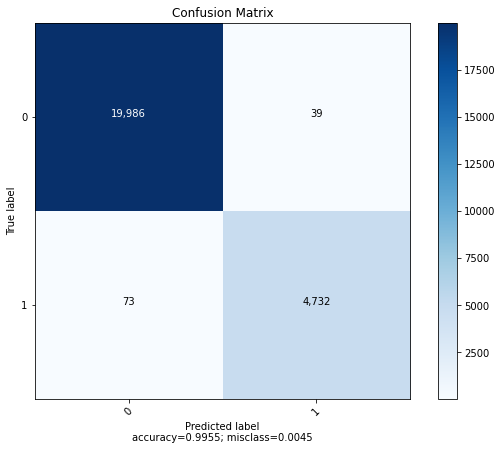

In [60]:
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

In [61]:
print ('precision ',round(precision_score(y_test, Preds),3))
print ('recall ',round(recall_score(y_test, Preds),3 ))
print ('accuracy ',round(accuracy_score(y_test, Preds),3))
print ('F1 score ',round(f1_score(y_test, Preds),3))

precision  0.992
recall  0.985
accuracy  0.995
F1 score  0.988


AUC: 0.991


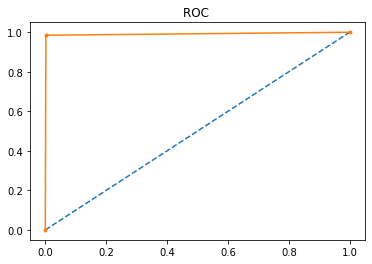

In [62]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
# show the plot
plt.show()

f1=0.988 ap=0.980


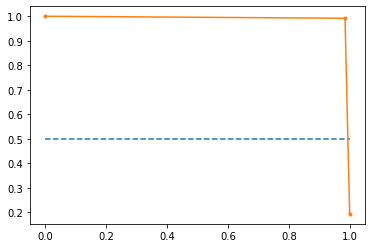

In [63]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate precision-recall AUC
#auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

## Feature importance - What features have the biggest impact on predictions

In [64]:
# Feature importance

importance = model.feature_importances_
FIdf = pd.DataFrame()
FIdf['Feature'] = X.columns
FIdf['Importance'] = importance

FIdf.sort_values(by=['Importance'], ascending=False, inplace=True)
FIdf.head(20)

,Feature,Importance
29,Age,0.087310
78,Obs8,0.064777
85,Obs15,0.062405
81,Obs11,0.048582
82,Obs12,0.046199
110,Encounter0,0.039712
80,Obs10,0.036859
70,Obs0,0.029068
88,Obs18,0.027915
71,Obs1,0.027616


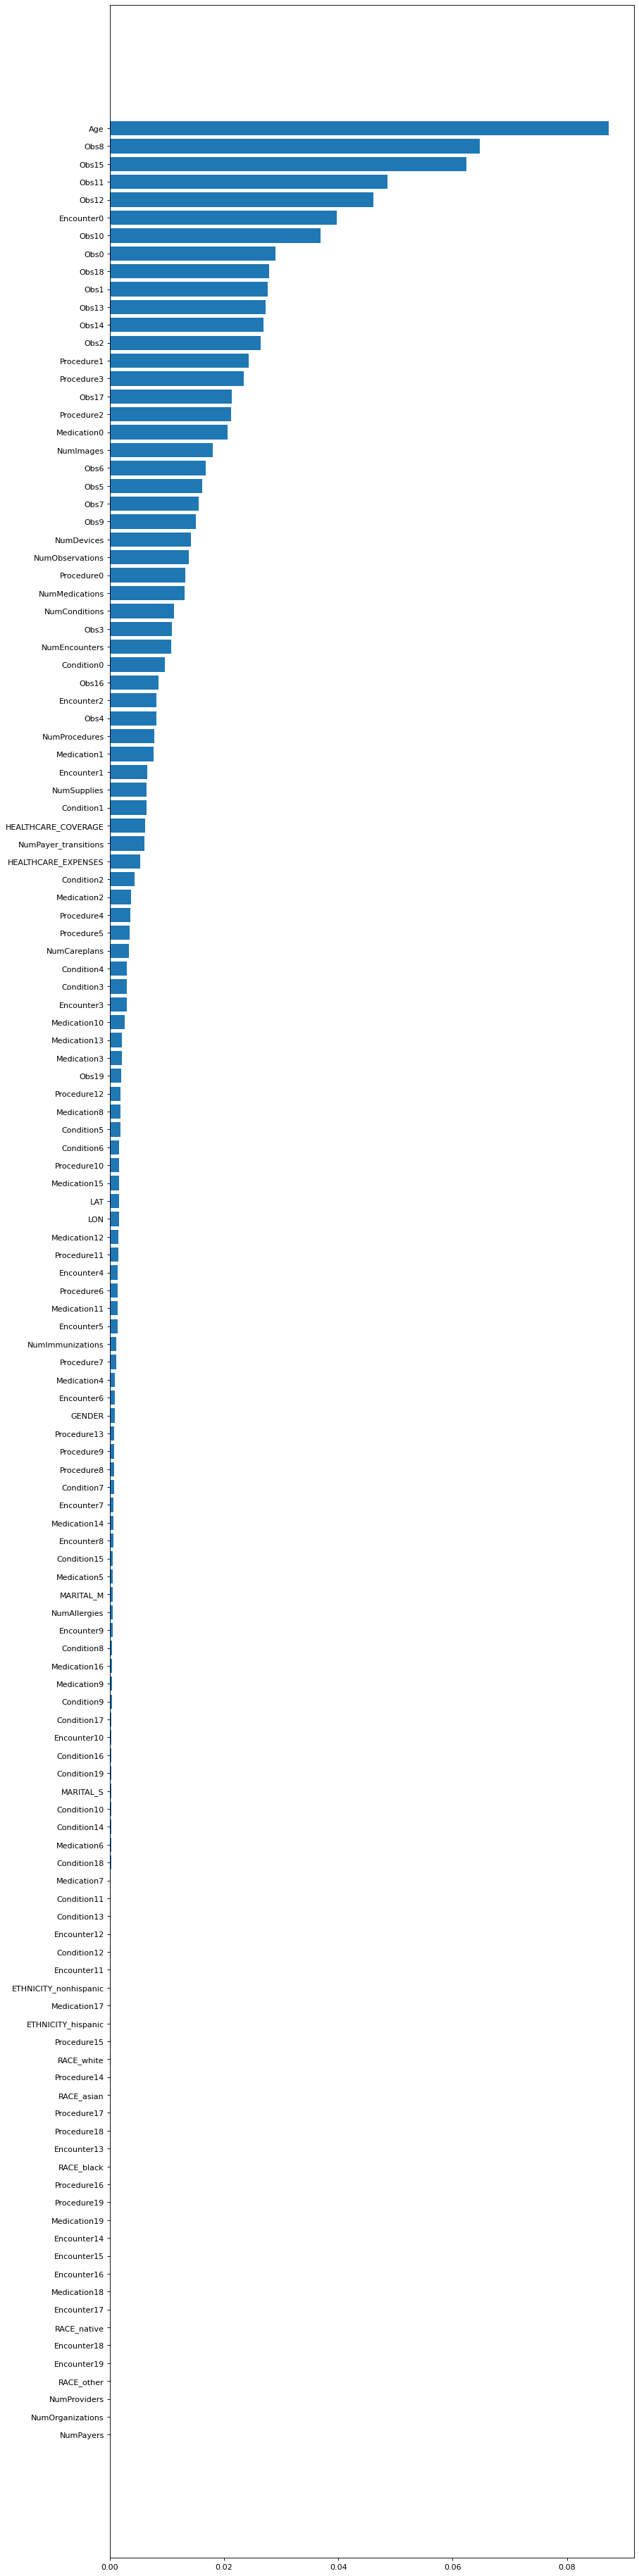

In [65]:
FIdf.sort_values(by=['Importance'], ascending=True, inplace=True)
figure(figsize=(12, 60), dpi=80)

plt.barh(FIdf['Feature'].astype(str), FIdf['Importance'])
plt.show()

## Partial Dependence Plots - How ONE feature affects predictions

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

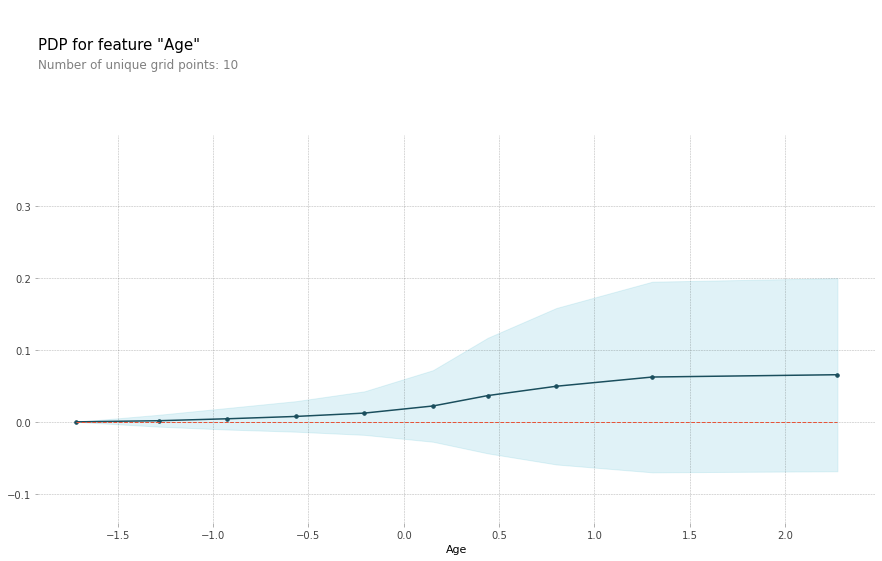

In [66]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature='Age')

# plot it
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

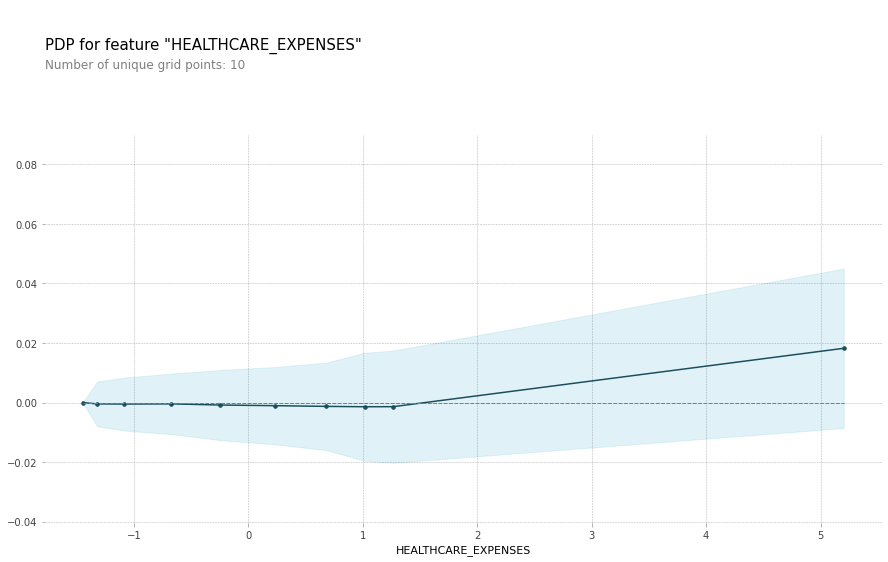

In [67]:
# Create the data for PDP
pdp_goals = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature='HEALTHCARE_EXPENSES')

# plot it
pdp.pdp_plot(pdp_goals, 'HEALTHCARE_EXPENSES')
plt.show()

## SHAP - Impact of each feature on ONE prediction

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

In [68]:
row_to_show = np.where(y==True)[0][1234]

data_for_prediction = X.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

model.predict_proba(data_for_prediction_array)

array([[0., 1.]])

In [69]:
 # SHAP

explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [70]:
# Following will work ONLY with the LAST embeddings

# Reverse from ONE vector to ONE concept

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

myIx = find_nearest(embeddings, -0.02698)[0]
print(reverse_word_index.get(myIx))

patient_encounter_procedure


In [71]:
row_to_show = np.where(y==False)[0][1234]

data_for_prediction = X.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

model.predict_proba(data_for_prediction_array)

array([[1., 0.]])

In [72]:
 # SHAP

explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)